"""Loading data sets"""


In [10]:
import numpy as np
import pandas as pd


In [11]:

def add_rul_1(df):
    """
    :无变换点
    :param df: 原始数据框架
    :return: 标记目标的数据框架
    """
    # 对每个单元获取总循环次数
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    print(max_cycle)
    # 将最大循环次数合并回原始框架
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    # 计算每行的剩余使用寿命（线性片段）
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    # print(remaining_useful_life)
    result_frame["RUL_1"] = remaining_useful_life
    # 删除不再需要的最大循环列
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

def add_rul_2(df):
    """
    ：固定变换点
    :param df: 原始数据框架
    :return: 包含新RUL的数据框架
    """
    # 对每个单元获取总循环次数
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # 将最大循环次数合并回原始框架
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # 计算所有单元的固定变换点
    min_max_cycle = result_frame["max_cycle"].min() - 120  # 找出所有单元中最小的最大循环次数并计算变换点
    result_frame['change_point'] = min_max_cycle  # 设定固定变换点

    # 生成新的RUL预测列
    result_frame["RUL_2"] = np.where(
        result_frame["time_cycles"] < result_frame['change_point'],
        result_frame["max_cycle"] - result_frame['change_point'],  # 当time_cycles小于change_point时，使用max_cycle的值
        result_frame["max_cycle"] - result_frame["time_cycles"]  # 否则计算剩余使用寿命
    )

    # 删除不再需要的最大循环列
    result_frame = result_frame.drop(["max_cycle", "change_point"], axis=1)

    return result_frame


def add_rul_3(df):
    """
    ：变换变换点
    :param df: 原始数据框架
    :return: 包含随机变换点RUL的数据框架
    """
    # 对每个单元获取总循环次数
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # 将最大循环次数合并回原始框架
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # 为每个单元生成一个介于120到130之间的随机数作为变换点的基数
    result_frame['random_shift'] = np.random.randint(120, 131, size=result_frame.shape[0])

    # 计算变换变换点
    result_frame['change_point'] = result_frame['max_cycle'] - result_frame['random_shift']

    # 生成新的RUL预测列
    result_frame["RUL_2"] = np.where(
        result_frame["time_cycles"] < result_frame['change_point'],
        result_frame["max_cycle"] - result_frame['change_point'],  # 当time_cycles小于change_point时，使用max_cycle的值
        result_frame["max_cycle"] - result_frame["time_cycles"]  # 否则计算剩余使用寿命
    )

    # 删除不再需要的列
    result_frame = result_frame.drop(["max_cycle", "change_point", "random_shift"], axis=1)

    return result_frame

In [12]:
# train_norm = add_rul_1(train_norm)
# train_norm.head(5)

In [19]:
def load_FD001(cut):
    """
    :param cut: 目标RUL的上限
    :return: 按样本分组的数据
    """
    # 定义文件路径
    dir_path = './CMAPSSData/'
    # 定义列名便于索引
    index_names = ['unit_nr', 'time_cycles']
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
    col_names = index_names + setting_names + sensor_names
    # 读取数据
    train = pd.read_csv((dir_path + 'train_FD001.txt'), sep='\s+', header=None, names=col_names)
    test = pd.read_csv((dir_path + 'test_FD001.txt'), sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv((dir_path + 'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])
    # 基于EDA去除非信息特征
    drop_sensors = ['s_1', 's_5', 's_6', 's_10', 's_14', 's_16', 's_18', 's_19']
    drop_labels = setting_names + drop_sensors
    train.drop(labels=drop_labels, axis=1, inplace=True)

    # 选择训练数据中的索引列（单元号和循环次数）
    title = train.iloc[:, 0:2]
    # 选择训练数据中的数据列
    data = train.iloc[:, 2:]

    # 对每个传感器信号应用Savitzky-Golay滤波（完成图3数据准备完成第3步骤）
    frame_length = 51  # 帧长，必须是奇数
    poly_order = 3  # 多项式阶数
    for sensor in sensor_names:
        if sensor in data.columns:  # 确保只对存在于DataFrame中的传感器进行操作
            data[sensor] = savgol_filter(data[sensor], frame_length, poly_order)
            data[sensor] = savgol_filter(data[sensor], frame_length, poly_order)

    # 对数据进行最小-最大规范化
    data_norm = (data - data.min()) / (data.max() - data.min())  # 最小-最大规范化
    train_norm = pd.concat([title, data_norm], axis=1)

    # 添加剩余使用寿命(RUL)列
    train_norm = add_rul_3(train_norm)

    # 按单元号分组
    group = train_norm.groupby(by="unit_nr")

    # 对测试数据重复上述删除特征和规范化的过程
    test.drop(labels=drop_labels, axis=1, inplace=True)
    title = test.iloc[:, 0:2]
    data = test.iloc[:, 2:]
    data_norm = (data - data.min()) / (data.max() - data.min())
    test_norm = pd.concat([title, data_norm], axis=1)

    # 按单元号对测试数据分组
    group_test = test_norm.groupby(by="unit_nr")

    # 返回处理后的训练数据组、测试数据组和测试数据的真实RUL值
    return group, group_test, y_test


In [21]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class LSTM1(nn.Module):
    """LSTM architecture"""
    # 初始化函数定义模型的基本结构
    def __init__(self, input_size, hidden_size, num_layers, seq_length=1):
        super(LSTM1, self).__init__()
        self.input_size = input_size  # 输入层大小
        self.hidden_size = hidden_size  # 隐藏层大小
        self.num_layers = num_layers  # LSTM层数
        self.seq_length = seq_length  # 序列长度

        # 定义LSTM层
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            dropout=0.1)
        # 定义全连接层
        self.fc_1 = nn.Linear(hidden_size, 16)  # 第一全连接层，16个节点
        self.fc_2 = nn.Linear(16, 8)  # 第二全连接层，8个节点
        self.fc = nn.Linear(8, 1)  # 输出层

        # 定义Dropout和ReLU激活函数
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    # 前向传播函数
    def forward(self, x):
        """
        :param x: 输入特征
        :return: 预测结果
        """
        # 初始化隐藏状态和内部状态
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # LSTM层输出
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        # 选择最后一层的隐藏状态
        hn_o = torch.Tensor(hn.detach().numpy()[-1, :, :])
        hn_o = hn_o.view(-1, self.hidden_size)
        hn_1 = torch.Tensor(hn.detach().numpy()[1, :, :])
        hn_1 = hn_1.view(-1, self.hidden_size)

        # 应用全连接层和激活函数
        out = self.relu(self.fc_1(self.relu(hn_o + hn_1)))
        out = self.relu(self.fc_2(out))
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [22]:
# 函数 testing_function
# 定义了一个用于测试模型的函数，接收参数为测试集数量和测试数据分组。
# 在一个循环中，对每个测试样本进行预测，并计算预测值和真实值之间的均方根误差（RMSE）。
# 使用torch.Tensor将测试数据转换为张量，并通过模型进行预测。
# 计算每个预测值与实际值的误差，累加后计算RMSE。
# 返回所有测试样本的预测结果和计算出的RMSE。
# 函数 train
# 接收初始化后的模型、训练集样本数量和训练数据分组作为参数。
# 定义了一个循环，用于执行多个训练周期（epochs）。
# 在每个epoch内部，使用train()方法设置模型到训练模式。
# 遍历所有训练样本，将数据转换为张量，执行前向传播，计算损失，进行反向传播，并更新模型权重。
# 每个epoch结束时，调用测试函数评估模型性能，打印损失和RMSE，如果模型在测试集上的性能没有改进，则提前终止训练。
# 返回训练过程中得到的最佳结果和对应的RMSE。




"""RUL Prediction with LSTM"""
# from loading_data import *
# from model import *
# from visualize import *
import numpy as np

N_HIDDEN = 96  # NUMBER OF HIDDEN STATES
N_LAYER = 4  # NUMBER OF LSTM LAYERS
N_EPOCH = 150  # NUM OF EPOCHS
MAX = 135  # UPPER BOUND OF RUL
LR = 0.01  # LEARNING RATE


def testing_function(num, group_for_test):
    rmse_test, result_test = 0, list()  # 初始化RMSE为0，result_test为空列表，用于存储测试结果。

    for ite in range(1, num + 1):  # 遍历测试数据集中的每一个样本。
        X_test = group_for_test.get_group(ite).iloc[:, 2:]  # 从测试数据中获取特征数据。
        X_test_tensors = Variable(torch.Tensor(X_test.to_numpy()))  # 将测试数据转换为PyTorch张量。
        X_test_tensors = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))  # 调整张量形状以适应模型输入。

        test_predict = model.forward(X_test_tensors)  # 使用模型进行前向传播得到预测结果。
        data_predict = max(test_predict[-1].detach().numpy(), 0)  # 获取最后一次的预测值，并确保其不小于0。
        result_test.append(data_predict)  # 将预测结果添加到结果列表中。
        rmse_test = np.add(np.power((data_predict - y_test.to_numpy()[ite - 1]), 2), rmse_test)  # 计算RMSE。

    rmse_test = (np.sqrt(rmse_test / num)).item()  # 计算最终的RMSE值。
    return result_test, rmse_test  # 返回所有测试样本的预测结果和RMSE。

def train(model_for_train, ntrain, group_for_train):
    rmse_temp = 100  # 初始化临时RMSE为100，作为性能比较的基准。

    for epoch in range(1, N_EPOCH + 1):  # 进行多个训练周期的迭代。

        model_for_train.train()  # 将模型设置为训练模式。
        epoch_loss = 0  # 初始化该周期的损失总和为0。

        for i in range(1, ntrain + 1):  # 遍历训练集中的每一个样本。
            X, y = group_for_train.get_group(i).iloc[:, 2:-1], group_for_train.get_group(i).iloc[:, -1:]  # 提取特征和目标变量。
            X_train_tensors = Variable(torch.Tensor(X.to_numpy()))  # 将特征数据转换为张量。
            y_train_tensors = Variable(torch.Tensor(y.to_numpy()))  # 将目标数据转换为张量。
            X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))  # 调整张量形状。

            outputs = model_for_train(X_train_tensors)  # 进行前向传播得到输出。
            optimizer.zero_grad()  # 清除之前的梯度信息。
            loss = criterion(outputs, y_train_tensors)  # 计算损失。
            epoch_loss += loss.item()  # 累加损失。
            loss.backward()  # 进行反向传播计算梯度。
            optimizer.step()  # 根据梯度更新模型参数。

        if epoch % 1 == 0:  # 每个周期结束后评估模型性能。
            model_for_train.eval()  # 设置模型为评估模式。
            result, rmse = testing_function(num_test, group_test)  # 调用测试函数得到性能指标。

            if rmse_temp < rmse and rmse_temp < 25:  # 如果新的RMSE没有改善且低于25，则停止训练。
                result, rmse = result_temp, rmse_temp
                break

            rmse_temp, result_temp = rmse, result  # 更新最佳RMSE和结果。
            print("Epoch: %d, loss: %1.5f, rmse: %1.5f" % (epoch, epoch_loss / ntrain, rmse))  #打印每个周期的损失和RMSE。

    return result, rmse  # 返回训练过程中的最佳结果和对应的RMSE。


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# def visualize(result, y_test, num_test, rmse):
#     """
#     可视化预测结果函数
#     :param result: 预测结果列表
#     :param y_test: 测试集的真实RUL值
#     :param num_test: 样本数量
#     :param rmse: 预测结果的均方根误差
#     """
#     result = y_test.join(pd.DataFrame(result))  # 将预测结果与真实RUL值合并为一个DataFrame
#     result = result.sort_values('RUL', ascending=False)  # 按照RUL值降序排序

#     # 提取真实和预测的RUL值
#     true_rul = result.iloc[:, 0].to_numpy()  # 真实的剩余使用寿命
#     pred_rul = result.iloc[:, 1].to_numpy()  # 预测的剩余使用寿命

#     plt.figure(figsize=(10, 6))  # 设置图形大小
#     plt.axvline(x=num_test, c='r', linestyle='--')  # 绘制红色虚线标示训练集大小

#     plt.plot(true_rul, label='Actual RUL')  # 绘制真实RUL曲线
#     plt.plot(pred_rul, label='Predicted RUL (RMSE = {})'.format(round(rmse, 3)))  # 绘制预测RUL曲线，并显示RMSE
#     plt.title('Remaining Useful Life Prediction')  # 图表标题
#     plt.legend()  # 显示图例
#     plt.xlabel("Samples")  # X轴标签
#     plt.ylabel("Remaining Useful Life")  # Y轴标签
#     plt.savefig('./_trials/{} RUL Prediction with LSTM.png'.format(round(rmse, 3)))  # 保存图形到文件
#     plt.show()  # 显示图形



def visualize_save_data(result, y_test, num_test, rmse, save_data=True):
    result_df = y_test.join(pd.DataFrame(result))  # 将预测结果与真实RUL值合并为一个DataFrame
    result_df = result_df.sort_values('RUL', ascending=False)  # 按照RUL值降序排序

    # 如果选择保存数据
    if save_data:
        # 保存数据到CSV文件
        result_df.to_csv(f'./_trials/without_change_point_RUL_Prediction_{round(rmse, 3)}.csv', index=False)

    # 绘图
    true_rul = result_df.iloc[:, 0].to_numpy()  # 真实的剩余使用寿命
    pred_rul = result_df.iloc[:, 1].to_numpy()  # 预测的剩余使用寿命

    plt.figure(figsize=(10, 6))
    plt.axvline(x=num_test, c='r', linestyle='--')
    plt.plot(true_rul, label='Actual RUL')
    plt.plot(pred_rul, label='without_change_point_Predicted RUL (RMSE = {})'.format(round(rmse, 3)))
    plt.title('Remaining Useful Life Prediction')
    plt.legend()
    plt.xlabel("Samples")
    plt.ylabel("Remaining Useful Life")
    plt.savefig(f'./_trials/{round(rmse, 3)} without_change_point_RUL_Prediction_with_LSTM.png')
    plt.show()

# def redraw_visualization(csv_path):
#     # 从CSV文件中读取数据
#     result_df = pd.read_csv(csv_path)
#     true_rul = result_df.iloc[:, 0].to_numpy()
#     pred_rul = result_df.iloc[:, 1].to_numpy()

#     # 绘图
#     plt.figure(figsize=(10, 6))
#     plt.plot(true_rul, label='Actual RUL')
#     plt.plot(pred_rul, label='Predicted RUL')
#     plt.title('Reloaded Remaining Useful Life Prediction')
#     plt.legend()
#     plt.xlabel("Samples")
#     plt.ylabel("Remaining Useful Life")
#     plt.show()

# # 调用绘图函数
# redraw_visualization('./_trials/RUL_Prediction_0.123.csv')




In [24]:
    # group, group_test, y_test = load_FD001(MAX)

Epoch: 1, loss: 6609.63500, rmse: 41.63678
Epoch: 2, loss: 2118.03162, rmse: 41.78956
Epoch: 3, loss: 2089.25179, rmse: 41.52168
Epoch: 4, loss: 2045.71811, rmse: 41.08583
Epoch: 5, loss: 1995.27232, rmse: 40.58032
Epoch: 6, loss: 1958.95715, rmse: 40.12353
Epoch: 7, loss: 1922.42763, rmse: 39.55615
Epoch: 8, loss: 1873.51358, rmse: 38.78383
Epoch: 9, loss: 1796.27182, rmse: 37.87650
Epoch: 10, loss: 1747.56744, rmse: 36.76157
Epoch: 11, loss: 1630.81044, rmse: 35.43774
Epoch: 12, loss: 1520.88841, rmse: 33.99498
Epoch: 13, loss: 1423.56094, rmse: 32.84823
Epoch: 14, loss: 1313.96482, rmse: 32.03490
Epoch: 15, loss: 1251.50780, rmse: 31.98136
Epoch: 16, loss: 1211.60735, rmse: 32.10442
Epoch: 17, loss: 1199.17026, rmse: 32.27040
Epoch: 18, loss: 1162.84120, rmse: 32.31650
Epoch: 19, loss: 1178.28761, rmse: 32.26709
Epoch: 20, loss: 1167.58655, rmse: 31.80638
Epoch: 21, loss: 1156.46887, rmse: 31.85500
Epoch: 22, loss: 1187.11564, rmse: 32.03960
Epoch: 23, loss: 1164.41008, rmse: 31.488

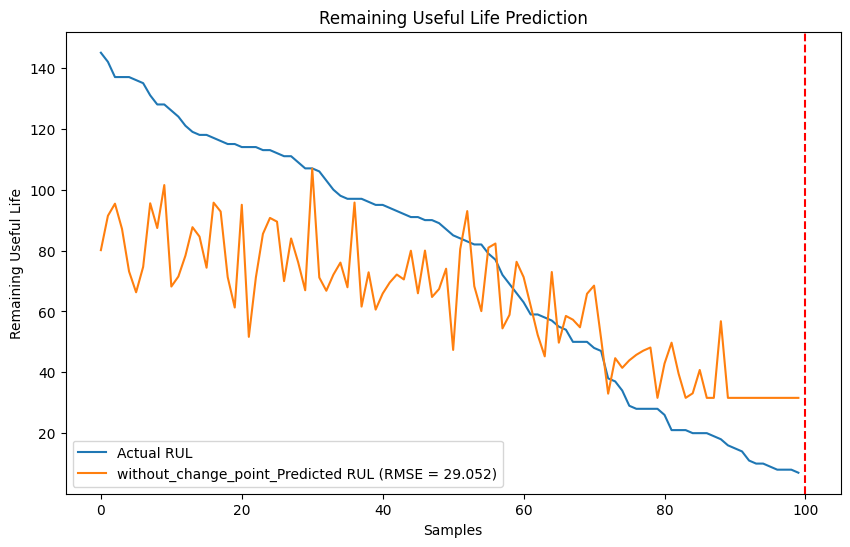

In [ ]:
if __name__ == "__main__":
    # 从数据集中获取基本信息
    group, group_test, y_test = load_FD001(MAX)  # 加载数据集并进行预处理，返回分组数据和测试数据的真实RUL值
    num_train, num_test = len(group.size()), len(group_test.size())  # 计算训练集和测试集中的样本数
    input_size = group.get_group(1).shape[1] - 3  # 计算模型输入特征的数量

    # 初始化LSTM模型
    model = LSTM1(input_size, N_HIDDEN, N_LAYER)  # 实例化LSTM模型，指定输入大小、隐藏层大小和层数
    criterion = torch.nn.MSELoss()  # 定义损失函数为均方误差
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # 定义优化器为Adam，设置学习率

    # 训练并评估模型
    result, rmse = train(model, num_train, group)  # 调用训练函数，训练模型并获取测试结果和RMSE
    # visualize(result, y_test, num_test, rmse)  # 调用可视化函数，显示预测结果和真实值的对比图
    visualize_save_data(result, y_test, num_test, rmse, save_data=True) ## # 调用visualize函数，启用数据保存功能



绘制三个图像

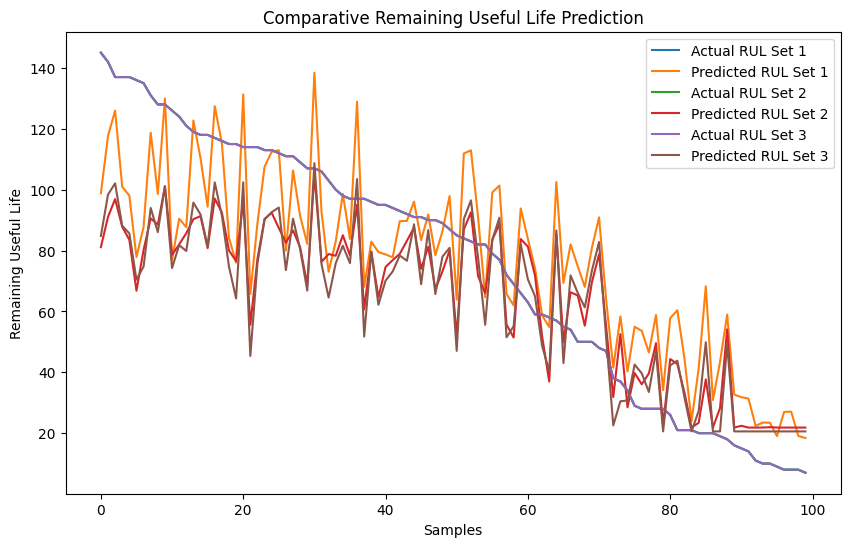

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

def redraw_visualizations(csv_paths):
    plt.figure(figsize=(10, 6))

    for idx, csv_path in enumerate(csv_paths):
        # 从CSV文件中读取数据
        result_df = pd.read_csv(csv_path)
        true_rul = result_df.iloc[:, 0].to_numpy()
        pred_rul = result_df.iloc[:, 1].to_numpy()

        # 绘图
        plt.plot(true_rul, label=f'Actual RUL Set {idx + 1}')
        plt.plot(pred_rul, label=f'Predicted RUL Set {idx + 1}')

    plt.title('Comparative Remaining Useful Life Prediction')
    plt.legend()
    plt.xlabel("Samples")
    plt.ylabel("Remaining Useful Life")
    plt.show()

# 调用绘图函数，传入三个CSV文件路径
csv_files = [
    './_trials/with_fixed_change_point_RUL_Prediction_23.889.csv',
    './_trials/with_moved_change_point_RUL_Prediction_25.705.csv',
    './_trials/without_change_point_RUL_Prediction_26.748.csv'
]
redraw_visualizations(csv_files)


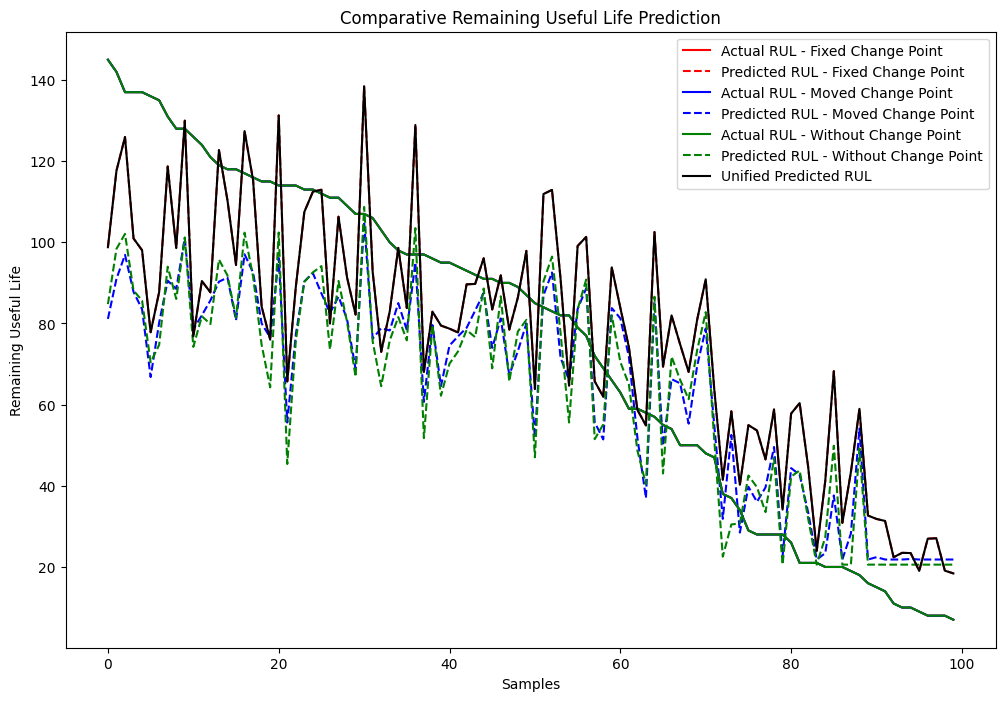

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def redraw_visualizations(csv_paths):
    plt.figure(figsize=(12, 8))  # 调整图像大小以更好地展示数据

    colors = ['red', 'blue', 'green']  # 定义颜色列表
    labels = [
        'Fixed Change Point',
        'Moved Change Point',
        'Without Change Point'
    ]  # 定义标签列表

    # 随机选择一个预测数据作为统一的预测RUL参考线
    selected_pred_index = np.random.randint(0, len(csv_paths))

    for idx, (csv_path, color, label) in enumerate(zip(csv_paths, colors, labels)):
        result_df = pd.read_csv(csv_path)
        true_rul = result_df.iloc[:, 0].to_numpy()
        pred_rul = result_df.iloc[:, 1].to_numpy()

        # 绘制每个文件的真实RUL曲线
        plt.plot(true_rul, color=color, label=f'Actual RUL - {label}')
        # 绘制每个文件的预测RUL曲线
        plt.plot(pred_rul, '--', color=color, label=f'Predicted RUL - {label}')

        # 使用随机选定的预测RUL作为统一的预测参考线
        if idx == selected_pred_index:
            unified_pred_rul = pred_rul  # 存储选定的预测RUL

    # 绘制统一的预测RUL曲线（黑色实线）
    plt.plot(unified_pred_rul, 'k-', label='Unified Predicted RUL')

    plt.title('Comparative Remaining Useful Life Prediction')
    plt.legend()
    plt.xlabel("Samples")
    plt.ylabel("Remaining Useful Life")
    plt.show()

# 指定文件路径
csv_files = [
    './_trials/with_fixed_change_point_RUL_Prediction_23.889.csv',
    './_trials/with_moved_change_point_RUL_Prediction_25.705.csv',
    './_trials/without_change_point_RUL_Prediction_26.748.csv'
]

# 调用绘图函数
redraw_visualizations(csv_files)


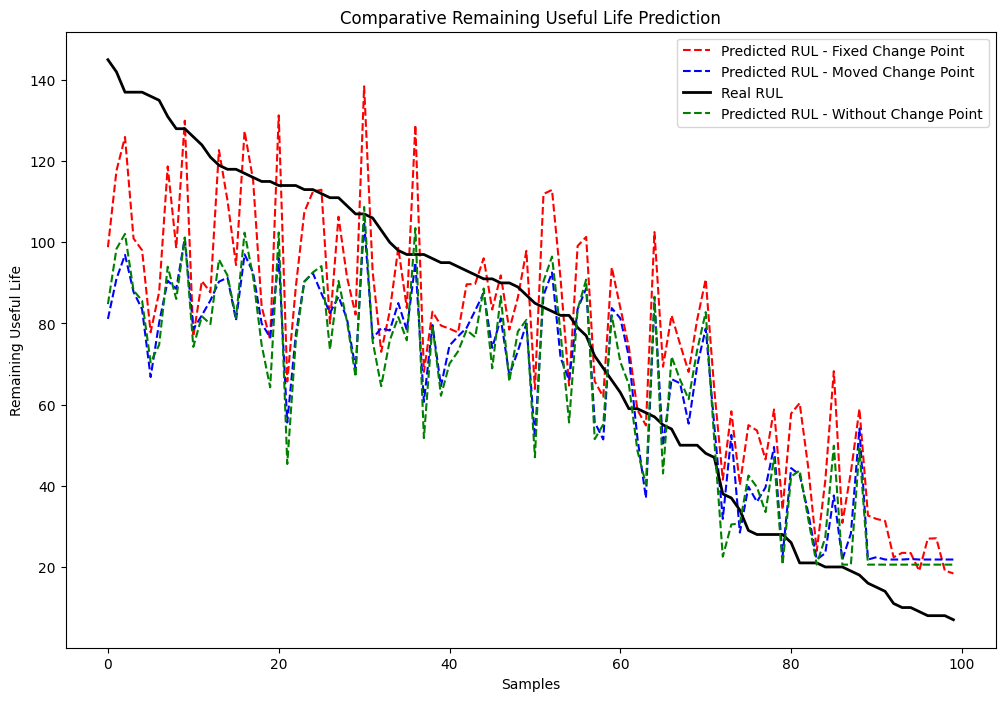

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def redraw_visualizations(csv_paths):
    plt.figure(figsize=(12, 8))  # 调整图像大小以更好地展示数据

    colors = ['red', 'blue', 'green']  # 定义颜色列表
    labels = [
        'Fixed Change Point',
        'Moved Change Point',
        'Without Change Point'
    ]  # 定义标签列表

    # 随机选择一个预测数据作为统一的预测RUL参考线
    selected_pred_index = np.random.randint(0, len(csv_paths))
    legend_added = False  # 标记是否已添加统一预测RUL的图例项

    for idx, (csv_path, color, label) in enumerate(zip(csv_paths, colors, labels)):
        result_df = pd.read_csv(csv_path)
        true_rul = result_df.iloc[:, 0].to_numpy()
        pred_rul = result_df.iloc[:, 1].to_numpy()

        # 绘制每个文件的真实RUL曲线
        # plt.plot(true_rul, color=color, label=f'Actual RUL - {label}')
        # 绘制每个文件的预测RUL曲线
        plt.plot(pred_rul, '--', color=color, label=f'Predicted RUL - {label}')

        # 使用随机选定的预测RUL作为统一的预测参考线，并确保图例只添加一次
        if idx == selected_pred_index and not legend_added:
            unified_pred_rul = true_rul  # 存储选定的预测RUL
            plt.plot(unified_pred_rul, 'k-', label='Real RUL', linewidth=2)  # 黑色实线
            legend_added = True  # 标记图例项已添加，防止重复添加

    plt.title('Comparative Remaining Useful Life Prediction')
    plt.legend()
    plt.xlabel("Samples")
    plt.ylabel("Remaining Useful Life")
    plt.show()

# 指定文件路径
csv_files = [
    './_trials/with_fixed_change_point_RUL_Prediction_23.889.csv',
    './_trials/with_moved_change_point_RUL_Prediction_25.705.csv',
    './_trials/without_change_point_RUL_Prediction_26.748.csv'
]

# 调用绘图函数
redraw_visualizations(csv_files)
